In [84]:
import obstacle_distance_and_gradient as Obt
import Jxt_function as Jxtfunct
import numpy as np
import matplotlib.pyplot as plt
import math
from J_x_t_function import J_x_t_func
import time

In [85]:
def dist_grad_closest(segment_info, x):
    A, B = segment_info
    AB = B - A
    t = np.dot(x - A, AB) / np.dot(AB, AB)
    t = np.clip(t, 0, 1)  # Clamp t to the segment
    closest = A + t * AB
    d = np.linalg.norm(x - closest)
    if d != 0:
        grad_d = (x - closest) / d
    else:
        grad_d = np.zeros_like(x)
    return d, grad_d, closest

def closest_point_on_square(obs_info, x_current):
    min_dist = float('inf')
    closest_pt = None
    closest_segment_key = None

    # Iterate through each line segment to find the closest point
    for key, segment in obs_info.items():
        d, _, pt = dist_grad_closest(segment, x_current)
        if d < min_dist:
            min_dist = d
            closest_pt = pt
            closest_segment_key = key

    return closest_pt, closest_segment_key

def compute_s_star_x_star(obs_info, segment_key, x_current):
    x_0 = obs_info[segment_key][1]
    x_1 = obs_info[segment_key][0]
    s_star = np.dot((x_current - x_0), (x_1 - x_0)) / (np.linalg.norm(x_1 - x_0))**2
    
    if s_star < 0:
        x_star = x_0
    elif s_star > 1:
        x_star = x_1
    else:
        x_star = (1 - s_star) * x_0 + s_star * x_1

    return s_star, x_star

import numpy as np

def compute_segments(obs_info):
    # Extract the diagonal vertices
    vertexA, vertexB = obs_info[0]
    
    # Identify the top-left and bottom-right vertices
    top_left = np.array([min(vertexA[0], vertexB[0]), max(vertexA[1], vertexB[1])])
    bottom_right = np.array([max(vertexA[0], vertexB[0]), min(vertexA[1], vertexB[1])])
    
    # Compute the other two vertices
    top_right = np.array([bottom_right[0], top_left[1]])
    bottom_left = np.array([top_left[0], bottom_right[1]])
    
    # Create the segments (edges) in clockwise order
    segment_info = {
        0: [top_right, top_left],
        1: [top_left, bottom_left],
        2: [bottom_left, bottom_right],
        3: [bottom_right, top_right]
    }
    
    return segment_info


In [86]:
def dist_grad_closest(segment_info, x):
    A, B = segment_info
    AB = B - A
    t = np.dot(x - A, AB) / np.dot(AB, AB)
    t = np.clip(t, 0, 1)  # Clamp t to the segment
    closest = A + t * AB
    d = np.linalg.norm(x - closest)
    if d != 0:
        grad_d = (x - closest) / d
    else:
        grad_d = np.zeros_like(x)
    return d, grad_d, closest

In [87]:
import numpy as np
import osqp
from scipy import sparse
class QPController:
    def __init__(self, config={}):
        self.k_cbf = 3  # Normal CBF coefficient
        self.k_cbf2 = 6  # Normal coefficient for new constraint
        self.epsilon = 0.4  # Finite time CLF coefficient

        self.num_of_states = 2
        self.num_of_control_inputs = 2

        self.u1_upper_lim = 10000
        self.u1_lower_lim = -10000
        self.u2_upper_lim = 10000
        self.u2_lower_lim = -10000

        self.dt = 0.1

        self.A = 0.50  # Normal parameter for new constraint
        self.sigma = 0.35  # Normal parameter for new constraint
        self.Jmax = 0.2  # Normal parameter for new constraint

        self.goal = None
        self.x_s = []
        self.gaussian = []

    def set_goal(self, goal):
        self.goal = goal

    def get_next_wp(self, action=None, curr_pose=None, curr_vel=None, obs_info={}):
        _, target_vel, target_pose = self.generate_control(curr_pose, obs_info)
        return None, target_vel, target_pose

    def generate_control(self, x_current, quad_rad, obs_info):
        k_ref_x1 = self.goal[0] - x_current[0]
        k_ref_x2 = self.goal[1] - x_current[1]

        num_of_obstacles = len(obs_info)
        A_list = []
        l_list = []
        
        for i in range(0,num_of_obstacles):

            rect = obs_info[i]
            box = Obt.Rectangle(rect[0],rect[1])
            top_left = np.array([x_current[0]-quad_rad , x_current[1] + quad_rad])
            top_right = np.array([x_current[0]+quad_rad , x_current[1] + quad_rad])
            bottom_left = np.array([x_current[0]-quad_rad , x_current[1] - quad_rad])
            bottom_right = np.array([x_current[0]+quad_rad , x_current[1] - quad_rad])
            
            d1= box.dist_grad_closest(top_left)[0] - quad_rad
            d2= box.dist_grad_closest(top_right)[0] - quad_rad
            d3= box.dist_grad_closest(bottom_left)[0] - quad_rad
            d4= box.dist_grad_closest(bottom_right)[0] - quad_rad
            
            grad_d1= box.dist_grad_closest(top_left)[1]
            grad_d2= box.dist_grad_closest(top_right)[1]
            grad_d3= box.dist_grad_closest(bottom_left)[1]
            grad_d4= box.dist_grad_closest(bottom_right)[1]
            
            min_distance = min(d1, d2, d3, d4)

            # Assign the appropriate grad_d based on the minimum distance value
            if min_distance == d1:
                grad_d = grad_d1
            elif min_distance == d2:
                grad_d = grad_d2
            elif min_distance == d3:
                grad_d = grad_d3
            else:
                grad_d = grad_d4

            d = min_distance
            

            A_list.append(grad_d)
            l_list.append(-self.k_cbf * d)

        # New constraint calculation
        segment_info = compute_segments(obs_info)
        closest_pt, closest_segment = closest_point_on_square(segment_info, x_current)
        s_star, x_star = compute_s_star_x_star(segment_info, closest_segment, x_current)

        norm = np.linalg.norm(x_star - x_current)
        if norm <= np.sqrt(self.A / self.sigma):
            gaus = self.A - (self.sigma * (norm**2))
        else:
            gaus = 0
        self.x_s.append(x_star)
        self.gaussian.append(gaus)
        gaus_differ = 2 * self.sigma * (x_star - x_current)

        func = J_x_t_func(self.gaussian)
        Jxt = func * self.dt

        A_list.append([-gaus_differ[0], -gaus_differ[1]])
        l_list.append(-self.k_cbf2 * (-gaus + ((self.Jmax - Jxt) * self.k_cbf)))

        A = sparse.csc_matrix(np.vstack(A_list))
        l = np.array(l_list)
        u = np.array([np.inf] * len(l_list))

        # Define the QP matrices
        P = sparse.diags([2, 2], format='csc')
        q = np.array([-2 * k_ref_x1, -2 * k_ref_x2])

        # Initialize a new OSQP solver instance and set up the problem
        solver = osqp.OSQP()
        solver.setup(P, q, A, l, u, verbose=False)
        result = solver.solve()

        if result.info.status != 'solved':
            raise ValueError("OSQP did not find a feasible solution.")

        # Extract the optimal control input
        control_u1, control_u2 = result.x
        target_vel = np.array([control_u1, control_u2])
        target_pose = x_current + target_vel * self.dt

        return None, target_vel, target_pose, d, grad_d

In [88]:
R1 = QPController()

In [89]:
R1 = QPController()

obs_info = {0: [np.array([1.0, 1.0]), np.array([0.0, 0.0])]}
goal = np.array([-2.0, -1.0])
x_current = np.array([3.0, 3.0])
x_current0 = np.array([3.0, 3.0])
quad_rad = 0.10
R1.set_goal(goal)
a = R1.generate_control(x_current, quad_rad, obs_info)

In [90]:
MPC = np.array([[ 3.00000000e+00,  3.00000000e+00],
 [ 2.90000000e+00, 2.90000000e+00],
 [ 2.80000000e+00, 2.80000000e+00],
 [ 2.70000000e+00, 2.70000000e+00],
 [ 2.60000000e+00, 2.60000000e+00],
 [ 2.50000000e+00, 2.50000000e+00],
 [ 2.39999999e+00, 2.39999999e+00],
 [ 2.29999999e+00, 2.29999999e+00],
 [ 2.19999999e+00, 2.19999999e+00],
 [ 2.09999999e+00, 2.09999999e+00],
 [ 1.99999999e+00, 2.01024265e+00],
 [ 1.89999999e+00, 1.94887170e+00],
 [ 1.79999999e+00, 1.91687047e+00],
 [ 1.69999999e+00, 1.91403240e+00],
 [ 1.59999999e+00, 1.94009538e+00],
 [ 1.49999999e+00, 1.99240457e+00],
 [ 1.39999998e+00, 2.03675785e+00],
 [ 1.29999998e+00, 2.06998450e+00],
 [ 1.19999998e+00, 2.09309964e+00],
 [ 1.09999998e+00, 2.10673702e+00],
 [ 9.99999980e-01, 2.11124562e+00],
 [ 8.99999979e-01, 2.11124562e+00],
 [ 7.99999978e-01, 2.11124562e+00],
 [ 6.99999977e-01, 2.11124562e+00],
 [ 5.99999976e-01, 2.11124562e+00],
 [ 4.99999975e-01, 2.11124562e+00],
 [ 3.99999974e-01, 2.11124562e+00],
 [ 2.99999973e-01, 2.11124562e+00],
 [ 1.99999972e-01, 2.11124562e+00],
 [ 9.99999715e-02, 2.11124562e+00],
 [-2.94902011e-08, 2.11124562e+00],
 [-1.00000030e-01, 2.10673701e+00],
 [-2.00000031e-01, 2.09309963e+00],
 [-3.00000032e-01, 2.06998449e+00],
 [-4.00000033e-01, 2.03675783e+00],
 [-5.00000034e-01, 1.99240455e+00],
 [-6.00000035e-01, 1.93534313e+00],
 [-7.00000036e-01, 1.86305664e+00],
 [-8.00000037e-01, 1.77127606e+00],
 [-9.00000038e-01, 1.67127606e+00],
 [-1.00000004e+00, 1.57127606e+00],
 [-1.09436219e+00, 1.47127606e+00],
 [-1.18010895e+00, 1.37127605e+00],
 [-1.25776136e+00, 1.27127605e+00],
 [-1.32806130e+00, 1.17127605e+00],
 [-1.39170306e+00, 1.07127605e+00],
 [-1.44931709e+00, 9.71276051e-01],
 [-1.50147429e+00, 8.71276050e-01],
 [-1.54869149e+00, 7.71276049e-01],
 [-1.59143658e+00, 6.71276048e-01],
 [-1.63013312e+00, 5.71276048e-01],
 [-1.66516457e+00, 4.71276047e-01],
 [-1.69687806e+00, 3.71276046e-01],
 [-1.72558785e+00, 2.71276045e-01],
 [-1.75157843e+00, 1.71276044e-01],
 [-1.77510735e+00, 7.12760445e-02],
 [-1.79640776e+00,-2.87239388e-02],
 [-1.81569073e+00,-1.20594053e-01],
 [-1.83314733e+00,-2.03875485e-01],
 [-1.84895056e+00,-2.79278491e-01],
 [-1.86325701e+00,-3.47540597e-01],
 [-1.87620844e+00,-4.09337415e-01],
 [-1.88793319e+00,-4.65281235e-01],
 [-1.89854745e+00,-5.15926411e-01],
 [-1.90815639e+00,-5.61774797e-01],
 [-1.91685524e+00,-6.03280714e-01],
 [-1.92473018e+00,-6.40855453e-01],
 [-1.93185926e+00,-6.74871351e-01],
 [-1.93831312e+00,-7.05665479e-01],
 [-1.94415571e+00,-7.33542981e-01],
 [-1.94944493e+00,-7.58780103e-01],
 [-1.95423319e+00,-7.81626925e-01],
 [-1.95856793e+00,-8.02309840e-01],
 [-1.96249211e+00,-8.21033800e-01],
 [-1.96604462e+00,-8.37984346e-01],
 [-1.96926066e+00,-8.53329443e-01],
 [-1.97217210e+00,-8.67221150e-01],
 [-1.97480778e+00,-8.79797122e-01],
 [-1.97719383e+00,-8.91181977e-01],
 [-1.97935388e+00,-9.01488532e-01],
 [-1.98130935e+00,-9.10818914e-01],
 [-1.98307961e+00,-9.19265582e-01],
 [-1.98468220e+00,-9.26912235e-01],
 [-1.98613301e+00,-9.33834645e-01],
 [-1.98744640e+00,-9.40101409e-01],
 [-1.98863540e+00,-9.45774624e-01],
 [-1.98971178e+00,-9.50910509e-01],
 [-1.99068622e+00,-9.55559955e-01],
 [-1.99156836e+00,-9.59769034e-01],
 [-1.99236695e+00,-9.63579457e-01],
 [-1.99308991e+00,-9.67028980e-01],
 [-1.99374439e+00,-9.70151786e-01],
 [-1.99433688e+00,-9.72978820e-01],
 [-1.99487325e+00,-9.75538095e-01],
 [-1.99535883e+00,-9.77854972e-01],
 [-1.99579841e+00,-9.79952409e-01],
 [-1.99619636e+00,-9.81851190e-01],
 [-1.99655661e+00,-9.83570130e-01],
 [-1.99688275e+00,-9.85126263e-01],
 [-1.99717800e+00,-9.86535010e-01],
 [-1.99744528e+00,-9.87810328e-01]])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Elapsed time: 2.42 seconds


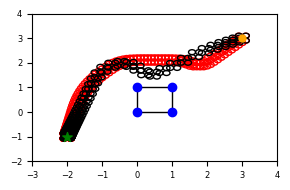

In [91]:
fig, ax = plt.subplots(figsize=(3.0, 2.0))
num_of_obstacles = len(obs_info)
for i in range(num_of_obstacles):
    top_right = obs_info[i][0]
    bottom_left = obs_info[i][1]
    width = top_right[0] - bottom_left[0]
    height = top_right[1] - bottom_left[1]
    ax.set_xlim(-3, 4)
    ax.set_ylim(-2, 4)
    square = plt.Rectangle(bottom_left, width, height, fill=False)
    ax.add_patch(square)

top_right = obs_info[0][0]
bottom_left = obs_info[0][1]
top_left = np.array([bottom_left[0], top_right[1]])
bottom_right = np.array([top_right[0], bottom_left[1]])
points = [top_left, top_right, bottom_right, bottom_left]
colors = ['b', 'b', 'b', 'b']
labels = [r'$q_{0}$ noise', r'$q_{1}$ noise', r'$q_{2}$ noise', r'$q_{3}$ noise']


for point in MPC:
    #plt.plot(point[0], point[1], 'ro')  # Red points
    circle = plt.Circle((point[0] - quad_rad, point[1] + quad_rad), radius=quad_rad, fill=False, color='red')
    circle1 = plt.Circle((point[0] + quad_rad, point[1] + quad_rad), radius=quad_rad, fill=False, color='red')
    circle2 = plt.Circle((point[0] - quad_rad, point[1] - quad_rad), radius=quad_rad, fill=False, color='red')
    circle3 = plt.Circle((point[0] + quad_rad, point[1] - quad_rad), radius=quad_rad, fill=False, color='red')
    plt.gca().add_patch(circle)
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.gca().add_patch(circle3)

for i, point in enumerate(points):
    plt.scatter(point[0], point[1], color=colors[i])

circle = plt.Circle((x_current[0] - quad_rad, x_current[1] + quad_rad), radius=quad_rad, fill=False)
circle1 = plt.Circle((x_current[0] + quad_rad, x_current[1] + quad_rad), radius=quad_rad, fill=False)
circle2 = plt.Circle((x_current[0] - quad_rad, x_current[1] - quad_rad), radius=quad_rad, fill=False)
circle3 = plt.Circle((x_current[0] + quad_rad, x_current[1] - quad_rad), radius=quad_rad, fill=False)
plt.gca().add_patch(circle)
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.gca().add_patch(circle3)

x_current_list = []
start_time = time.time()
for i in range(60):
    goal = np.array([-2.0, -1.0])
    R1.set_goal(goal)
    a = R1.generate_control(x_current, quad_rad, obs_info)
    h = a[2]
    x_current = h
    x_current_list.append(x_current)
  
    circle = plt.Circle((x_current[0] - quad_rad, x_current[1] + quad_rad), radius=quad_rad, fill=False)
    circle1 = plt.Circle((x_current[0] + quad_rad, x_current[1] + quad_rad), radius=quad_rad, fill=False)
    circle2 = plt.Circle((x_current[0] - quad_rad, x_current[1] - quad_rad), radius=quad_rad, fill=False)
    circle3 = plt.Circle((x_current[0] + quad_rad, x_current[1] - quad_rad), radius=quad_rad, fill=False)
    plt.gca().add_patch(circle)
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.gca().add_patch(circle3)

ax.scatter(goal[0], goal[1], marker='*', s=50, color='green')
ax.scatter(x_current0[0], x_current0[1], marker='.', s=100, color='orange')
#plt.plot([], [], 'o', color='red', label='MPC trajectory')
#plt.plot([], [], 'o', color='black', label='CBF trajectory')
#plt.plot([], [], 'o', color='blue', label=r'Discretized Set $\bar{Q}$')

ax.legend(loc='lower right', fontsize=5, ncol=1, frameon=False, 
          borderpad=0.5, labelspacing=0.5, handletextpad=0.5, markerscale=0.5)
ax.tick_params(axis='both', which='major', labelsize=6)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

plt.tight_layout()
#filename = 'CBF-QP-AND-MPC.png'  # or any other filename and format you prefer
#plt.savefig(filename, format='png', dpi=300)
plt.show()

In [22]:
x_current_list[249]

IndexError: list index out of range

In [ ]:
x_s_list = R1.x_s

In [ ]:
x_bar_noise = []
for a in range (len(x_current_list)):
    point_on_the_line = dist_grad_closest(obs_info[0], x_current_list[a])[2]
    x_bar_noise.append(point_on_the_line)

In [ ]:
len(x_s_list)

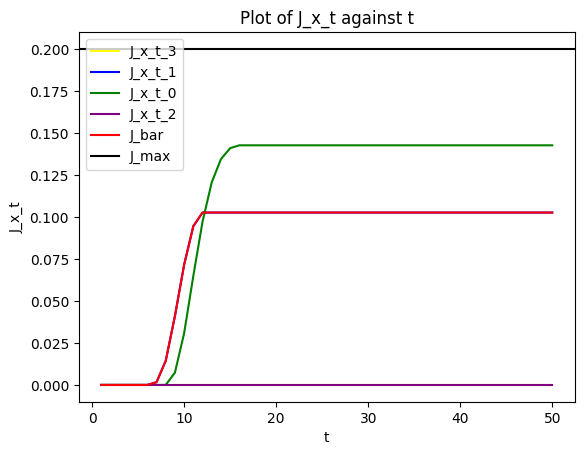

In [92]:
sigma = 0.35
A = 0.5
J_x_t_1 = []
J_x_t_2 = []
J_x_t_4 = []
J_x_t_5 = []
J_bar = []
x_0_noise = obs_info[0][1]
x_1_noise = obs_info[0][0]
x_2_noise = np.array([x_0_noise[0], x_1_noise[1]])
x_3_noise = np.array([x_1_noise[0], x_0_noise[1]])

parabolic_1 = []
parabolic_2 = []
parabolic_3 = []
parabolic_4 = []
parabolic_5 = []
sqrt_a_sigma = math.sqrt(A/sigma)
for t in range(1, len(x_current_list) + 1):
    x_current = x_current_list[t-1]
    if np.linalg.norm(x_0_noise - x_current) <= sqrt_a_sigma:
        gaus = A - (sigma * (np.linalg.norm(x_0_noise - x_current)**2))
    else:
        gaus = 0
    parabolic_1.append(gaus)
    
    if len(parabolic_1) == 1:
        J_x_t = 0
    elif len(parabolic_1) > 1:
        J_x_of_t = J_x_t_func(parabolic_1)
        J_x_t = J_x_of_t * 0.1
        
    J_x_t_1.append(J_x_t)
    
for s in range(1, len(x_current_list) + 1):
    x_current_2 = x_current_list[s-1]
    if np.linalg.norm(x_1_noise - x_current_2) <= sqrt_a_sigma:
        gaus2 = A - (sigma * (np.linalg.norm(x_1_noise - x_current_2)**2))
    else:
        gaus2 = 0
    
    #gaus2 = A * np.exp(-np.linalg.norm(x_noise - x_current_2)**2 / (2*sigma**2))
    parabolic_2.append(gaus2)
    
    if len(parabolic_2) == 1:
        J_x_ta = 0
    elif len(parabolic_2) > 1:
        J_x_of_t2 = J_x_t_func(parabolic_2)
        J_x_ta = J_x_of_t2 *0.1
        
    J_x_t_2.append(J_x_ta)
    
    
for v in range(1, len(x_current_list) + 1):
    x_current_4 = x_current_list[v-1]
    if np.linalg.norm(x_2_noise - x_current_4) <= sqrt_a_sigma:
        gaus4 = A - (sigma * (np.linalg.norm(x_2_noise - x_current_4)**2))
    else:
        gaus4 = 0
    
    #gaus2 = A * np.exp(-np.linalg.norm(x_noise - x_current_2)**2 / (2*sigma**2))
    parabolic_4.append(gaus4)
    
    if len(parabolic_4) == 1:
        J_x_ta = 0
    elif len(parabolic_4) > 1:
        J_x_of_t4 = J_x_t_func(parabolic_4)
        J_x_ta = J_x_of_t4 *0.1
        
    J_x_t_4.append(J_x_ta)

for y in range(1, len(x_current_list) + 1):
    x_current_5 = x_current_list[y-1]
    if np.linalg.norm(x_3_noise - x_current_5) <= sqrt_a_sigma:
        gaus5 = A - (sigma * (np.linalg.norm(x_3_noise - x_current_5)**2))
    else:
        gaus5 = 0
    
    #gaus2 = A * np.exp(-np.linalg.norm(x_noise - x_current_2)**2 / (2*sigma**2))
    parabolic_5.append(gaus5)
    
    if len(parabolic_5) == 1:
        J_x_ta = 0
    elif len(parabolic_5) > 1:
        J_x_of_t5 = J_x_t_func(parabolic_5)
        J_x_ta = J_x_of_t5 *0.1
        
    J_x_t_5.append(J_x_ta)

for u in range(1, len(x_current_list) + 1):
    x_noise_element = x_s_list[u-1]
    x_current_3 = x_current_list[u-1]
    if np.linalg.norm(x_noise_element - x_current_3) <= sqrt_a_sigma:
        gaus3 = A - (sigma * (np.linalg.norm(x_noise_element - x_current_3)**2))
    else:
        gaus3 = 0

    parabolic_3.append(gaus3)

    if len(parabolic_3) == 1:
        J_x_tb = 0
    elif len(parabolic_3) > 1:
        J_x_of_t3 = J_x_t_func(parabolic_3)
        J_x_tb = J_x_of_t3 *0.1

    J_bar.append(J_x_tb)


plt.plot(list(range(1, len(x_current_list) + 1)), J_x_t_1, label='J_x_t_3', color='yellow')
plt.plot(list(range(1, len(x_current_list) + 1)), J_x_t_2, label='J_x_t_1', color='blue')
plt.plot(list(range(1, len(x_current_list) + 1)), J_x_t_4, label='J_x_t_0', color='green')
plt.plot(list(range(1, len(x_current_list) + 1)), J_x_t_5, label='J_x_t_2', color='purple')
plt.plot(list(range(1, len(x_current_list) + 1)), J_bar, label='J_bar', color='red')
plt.axhline(y=0.20, color='black', linestyle='-', label="J_max")
plt.xlabel('t')
plt.ylabel('J_x_t')
plt.title('Plot of J_x_t against t')

# Display the legend
plt.legend()

# Show the plot
plt.show()

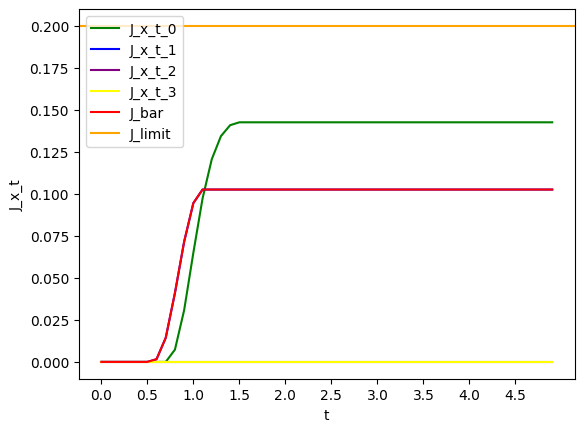

In [93]:
x_ticks = np.arange(0, len(x_current_list)) * 0.1
x_labels = [str(round(i, 1)) for i in x_ticks]

plt.plot(x_ticks, J_x_t_4, label='J_x_t_0', color='green')
plt.plot(x_ticks, J_x_t_2, label='J_x_t_1', color='blue')
plt.plot(x_ticks, J_x_t_5, label='J_x_t_2', color='purple')
plt.plot(x_ticks, J_x_t_1, label='J_x_t_3', color='yellow')
plt.plot(x_ticks, J_bar, label='J_bar', color='red')
plt.axhline(y=0.20, color='orange', linestyle='-', label="J_limit")

plt.xlabel('t')
plt.ylabel('J_x_t')
#plt.title('Plot of J_x_t against t')

# Set the x_ticks and x_labels
plt.xticks(x_ticks[::int(len(x_current_list) * 0.1)], x_labels[::int(len(x_current_list) * 0.1)])  # Adjust the ticks to be visible and not too crowded

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [107]:
J_bar

[0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0016284324798173711,
 0.014348926418452736,
 0.041058926819207094,
 0.07156557641713994,
 0.09452921170801422,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892,
 0.102604136342892]

In [88]:
x_0_noise = obs_info[0][1]
x_1_noise = obs_info[0][0]
x_2_noise = np.array([x_0_noise[0], x_1_noise[1]])
x_3_noise = np.array([x_1_noise[0], x_0_noise[1]])
x_3_noise

array([1., 0.])

In [89]:
J_bar_dot = parabolic_3

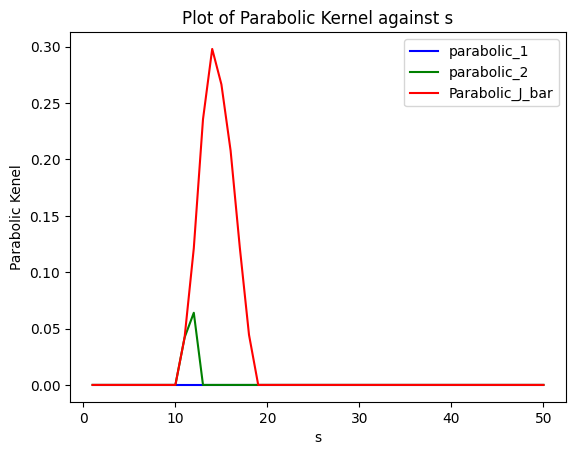

In [90]:
plt.plot(list(range(1, len(parabolic_1) + 1)), parabolic_1, label='parabolic_1', color='blue')
plt.plot(list(range(1, len(parabolic_2) + 1)), parabolic_2, label='parabolic_2', color='green')
plt.plot(list(range(1, len(parabolic_3) + 1)), parabolic_3, label='Parabolic_J_bar', color='red')
plt.xlabel('s')
plt.ylabel('Parabolic Kenel')
plt.title('Plot of Parabolic Kernel against s')

# Display the legend
plt.legend()


In [31]:
maximum = max(parabolic_3)
maximum

0.43804069939604423

In [13]:
index = parabolic_3.index(maximum)
index

53

In [14]:
s_ = index/len(parabolic_3)
s_

0.212

In [15]:
x_s = dist_grad_closest(obs_info[0], x_current_list[index])[2]
x_s

array([0.0160343, 1.       ])

In [16]:
q_t = x_current_list[index]
q_t

array([0.0160343 , 1.20146986])

In [17]:
x_0 = obs_info[0][1]
x_1 = obs_info[0][0]


In [18]:
s_star = np.dot((q_t -x_0), (x_1 - x_0)) / (np.linalg.norm(x_1 -x_0))**2
s_star
if s_star < 0:
    x_star = x_0
elif s_star > 1:
    x_star = x_1
else:
    x_star = (1-s_star)*x_0 + s_star*x_1
    
print (x_star)

[0.0160343 1.       ]


In [19]:
J_bar_dot_x_star = []
for s in range(1, len(x_current_list) + 1):
    x_current_2 = x_current_list[s-1]
    if np.linalg.norm(x_star - x_current_2) <= sqrt_a_sigma:
        para1 = A - (sigma * (np.linalg.norm(x_star - x_current_2)**2))
    else:
        para1 = 0
    
    #gaus2 = A * np.exp(-np.linalg.norm(x_noise - x_current_2)**2 / (2*sigma**2))
    J_bar_dot_x_star.append(para1)

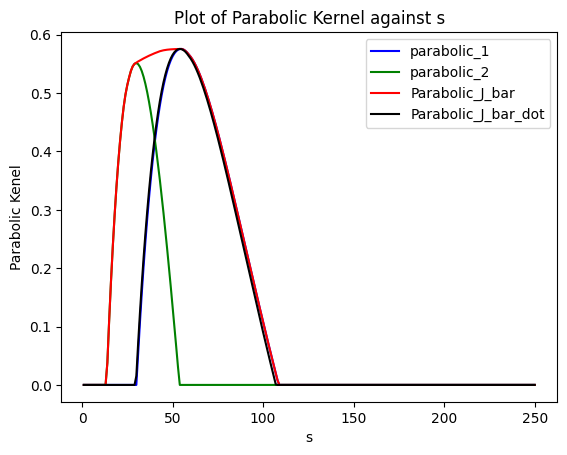

In [20]:
plt.plot(list(range(1, len(parabolic_1) + 1)), parabolic_1, label='parabolic_1', color='blue')
plt.plot(list(range(1, len(parabolic_2) + 1)), parabolic_2, label='parabolic_2', color='green')
plt.plot(list(range(1, len(parabolic_3) + 1)), parabolic_3, label='Parabolic_J_bar', color='red')
plt.plot(list(range(1, len(J_bar_dot_x_star) + 1)), J_bar_dot_x_star, label='Parabolic_J_bar_dot', color='black')
plt.xlabel('s')
plt.ylabel('Parabolic Kenel')
plt.title('Plot of Parabolic Kernel against s')

# Display the legend
plt.legend()

In [21]:
s = (x_s[0] - x_0[0]) / (x_1[0] - x_0[0])
s

0.016034295652206376

In [22]:
x_current_list[249]

array([-1.47109357,  1.00421929])